In [10]:
def get_softmaxed(model, state, possible_actions):
    values = [i for i in range(len(possible_actions))]

    smallest = float(math.inf)
    for action in possible_actions:
        values[action] = model.predict_value([state], [action])
        smallest = min(smallest, values[action])
        
    print("before before" , values)
    smallest = abs(smallest)
    # make all positive
    for action in possible_actions:
        print(action)
        values[action] += smallest

    print("before", values)
    values = np.array(values)
    values = np.exp(values) / np.sum(np.exp(values), axis=0)
    return values
    


In [4]:
ds = CreateDataset()
# ds.loadFilesFromDir('events/*.json')
ds.loadTrackingContentFromDir('three-sixty/*.json')

ds.loadFilesFromDir('events/*.json', filterGamesWithoutTrackingData=True)
# ds.loadFile('data.json')

visualiser = Visualiser()

# ds.loadFilesFromDir('events/*.json')

print("hello")
observations, actions, rewards, event_ids = ds.createEpisodeDataset()
answers = {}
players = {}

a_set = set()
for a in actions:
    a_set.add(a)

for item in a_set:
    print(ds.ID_to_str[item])


print(observations.shape, len(event_ids))
for i, situation in tqdm(enumerate(observations)):

    # print(situation)
    predictions = m2.predict([situation])[0]
    g_s_m = get_softmaxed(m2, situation, list(ds.good_events.values()))
    print(g_s_m, sum(g_s_m))

    print("One Hot", m2.predict([situation])[0])
    for key, value in ds.good_events.items():
        print(key, value)
        print(f"{key}: ", m2.predict_value([situation], [value]))
        
    p = ds.ID_to_str[predictions]
    if not (p in answers): answers[p] = 1
    else: answers[p] += 1

    # if(p == "shot"):
    #     print(event_ids[i])
    #     print([ds.getPlayerFromActionID(event) for event in event_ids[i]])
    event = ds.getActionFromID(event_ids[i][-2])
    
    if(p == "shot"):

        event = ds.getActionFromID(event_ids[i][-2])
        visualiser.visualise_sequence(situation, 3, predictions, ds.getIDFromAction(event))

    player = event['player']
    if not(player['id'] in players):
        players[player['id']] = {}
        players[player['id']]['name'] = player['name']
        players[player['id']]['good'] = 0
        players[player['id']]['bad'] = 0
        

    # print("Action taken:", ds.ID_to_str[ds.getIDFromAction(event)], p)
    if predictions ==  ds.getIDFromAction(event):
        players[player['id']]['good'] += 1
    else:
        players[player['id']]['bad'] += 1

    if((players[player['id']]['good'] + players[player['id']]['bad']) > 0):
        players[player['id']]['ratio'] = players[player['id']]['good'] / (players[player['id']]['good'] + players[player['id']]['bad']) 
    else:
        players[player['id']]['ratio'] = 0
        
    
    # if(p == "clearance"):
    #     visualiser.visualise_sequence(situation, 3, predictions)

print("finished")

In [ ]:
players_2 = {}
for key, player in players.items():
    if 'good' in player and 'bad' in player and (player['good'] + player['bad'] > 5):
        players_2[key] = player


players_sorted =  sorted(players_2.items(), key=lambda x: x[1]['ratio'], reverse=True)
players_sorted[:10]


In [ ]:

players_sorted =  sorted(players_2.items(), key=lambda x: x[1]['ratio'], reverse=True)
players_sorted[:10]


In [ ]:
counts = {}

for item in actions:
    if not (item in counts): counts[item] = 1
    else: counts[item] += 1

counts


In [ ]:
import json

player_data = {}
events = {}
with open ("data.json", "r") as file:
    events = json.load(file)

ds.ID_to_str[predictions]

count = 0
for event in events:
    if event['type']['name'].lower() in ds.good_events:
        player = event['player']

        if player['id'] in player_data:
        else:
            player_data['id'] = {}
            player_data['id']['name'] = player['name']
            player_data['id']['good'] += 1

count


Import the required modules

In [1]:
from d3rlpy.datasets import get_cartpole
from d3rlpy.algos import DiscreteCQL, DQN, CQL, IQL, PLAS, TD3PlusBC, AWAC
from d3rlpy.metrics.scorer import discounted_sum_of_advantage_scorer
from d3rlpy.metrics.scorer import evaluate_on_environment
from d3rlpy.dataset import Episode
from d3rlpy.ope import DiscreteFQE
from d3rlpy.dataset import MDPDataset

from d3rlpy.metrics.scorer import td_error_scorer
from d3rlpy.metrics.scorer import average_value_estimation_scorer
from sklearn.model_selection import train_test_split

import import_ipynb
import numpy as np
from random import random
from create_dataset import CreateDataset
from tqdm import tqdm

from view import Visualiser
import math
# metrics to evaluate with
from d3rlpy.metrics.scorer import initial_state_value_estimation_scorer
from d3rlpy.metrics.scorer import soft_opc_scorer

In [ ]:
def create_dataset_images():

    datasetMaker = CreateDataset()
    datasetMaker.loadTrackingContentFromDir('three-sixty/*.json')
    datasetMaker.file_limit = 10
    datasetMaker.loadFilesFromDir('events/*.json', filterGamesWithoutTrackingData=True)
    observations, actions, rewards, event_ids, terminals = datasetMaker.createTileCodingDataset()

    print("Actions shape:", actions.shape)
    print("Observation shape:", observations.shape)

    return MDPDataset(
        observations,
        actions,
        rewards, 
        terminals,

        discrete_action=False
    ), (observations, actions, rewards, event_ids, terminals)

In [ ]:
# dataset, _split = create_dataset_images()
dataset, _split = create_dataset_images()

print(len(dataset))
train_episodes, test_episodes = train_test_split(dataset, test_size=0.2, shuffle=True)
len(dataset), len(train_episodes)

Train the model

In [ ]:
# setup td3 algorithm
td3pbc = TD3PlusBC(use_gpu=False, scaler='pixel', n_frames=1)

# start training
output = td3pbc.fit(

    train_episodes,
    n_epochs = 35,
    
    scorers={
        'advantage': discounted_sum_of_advantage_scorer, # smaller is better
        'td_error': td_error_scorer, # smaller is better
        'value_scale': average_value_estimation_scorer # smaller is better
    }
    
)

Loading an exsisting Model

In [37]:
drive_folder = "10"
path =  f"C:\\Users\\micha\\Documents\\Masters\\Football-RL\\d3rlpy_logs\\drive_trained\\{drive_folder}\\"
model_file = sorted([f for f in os.listdir(path) if f.endswith('.pt')])[0]

print("Loaded: ",drive_folder,"\\",model_file)
trained_model = TD3PlusBC.from_json(f'{path}params.json')
trained_model.load_model(f'{path}{model_file}')

Loaded:  10 \ model_7025.pt
2022-05-09 20:38.19 [warning  ] Unused arguments are passed.   algorithm=TD3PlusBC generated_maxlen=100000 real_ratio=1.0


Create a fake scenario to evaluate the model qualitatively

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [9]:
ds = CreateDataset()
params = []

def get_coords(event, x, y, flags, param):
    global params

    temp_a = None

    if event == cv2.EVENT_LBUTTONUP:
        print(x, y)
        temp_a = {
            "location" : [int(x/2),int(y/2)],
            "actor":False,
            "teammate":True,
            "keeper":False,
        }

    elif event == cv2.EVENT_MBUTTONUP:
        temp_a = {
            "location" : [int(x/2),int(y/2)],
            "actor":True,
            "teammate":True,
            "keeper":False,
        }

    elif event == cv2.EVENT_RBUTTONUP:
        temp_a = {
            "location" : [int(x/2),int(y/2)],
            "actor":False,
            "teammate":False,
            "keeper":False,
        }

    if temp_a is not None:
        params.append(temp_a)
        cv2.destroyAllWindows()

def predict_fake_scenario(params):
    player, team, opp = ds.drawSimple({'freeze_frame':params})
    situation = [player, team, opp]

    predictions = trained_model.predict(np.array([situation]))
    first_four = predictions[0][:4]

    # perform softmax activation on first_four
    first_four = np.exp(first_four)/np.sum(np.exp(first_four))

    # find which index has the largest value
    max_index = np.argmax(first_four)

    pred_x, pred_y = min(120, max(0, predictions[0][4])), min(80, max(0, predictions[0][5]))

    new_image = cv2.cvtColor(situation[0], cv2.COLOR_BGR2RGB)

    c1 = (39, 127, 255)
    c2 = (0,255,0)
    team_mates = (0,0,255)
    opp = (255,0,0)

    merged = np.zeros(new_image.shape, new_image.dtype)
    for h in range(merged.shape[0]):
        for j in range(merged.shape[1]):
            # green pixel
            merged[h][j] =  (18, 97, 41)


            if((situation[1][h][j] == 255).all()):
                merged[h][j] = (0,0,255)

            if((situation[2][h][j] == 255).all()):
                merged[h][j] = (255,0,0)

            # actor
            if((new_image[h][j] == 255).all()):
                merged[h][j] = (14,201,255)

    # resize merged by 2
    cv2.circle(merged, (int(pred_x * 120), int(pred_y*80)), 5, c2, 1)
    merged = cv2.resize(merged, (0, 0), fx=2, fy=2)
    # double the size of the new_image
    large = cv2.resize(new_image, (0, 0), fx=2, fy=2)

    # double the size of situation 2
    large2 = cv2.resize(situation[1], (0, 0), fx=2, fy=2)

    # double the size of situation 3
    large3 = cv2.resize(situation[2], (0, 0), fx=2, fy=2)

    plt.bar([ds.ID_to_str[i] for i in range(len(first_four))], first_four)

    plt.savefig('bar_chart.png', dpi=300)

    # clear the figure
    plt.clf()

    loaded = cv2.imread('bar_chart.png')
    loaded = cv2.resize(loaded, (large.shape[1] * 2, large.shape[0] * 2))
    cv2.imshow("bar charts", loaded )

    cv2.imshow("actor", large)
    cv2.imshow("team_mates", large2)
    cv2.imshow("opponents", large3)
    cv2.imshow("merged", merged)

    cv2.setMouseCallback('merged', get_coords)
    v = cv2.waitKey(0)
    cv2.destroyAllWindows()

    if v == ord('q'):
        return 'stop'
    elif v == ord('r'):
        return 'reset'
    else:
        return 'continue'

while(True):
    code = predict_fake_scenario(params)
    if(code == 'reset'): params = []
    if(code == 'stop'): break

118 50
73 127
100 133
105 31


<Figure size 432x288 with 0 Axes>

Qualitative model performance analysis

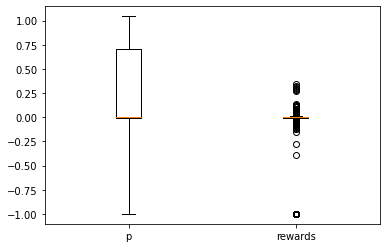

0.15430520018167154 -0.13105423874293393


In [36]:
p = np.array([a + 0.7 if a > 0 else a for a in rewards])

# draw boxplot of p and rewards with labels
plt.boxplot([p, rewards], labels=['p', 'rewards'])
# plt.boxplot([p, rewards])
plt.show()

# output the average of p and rewards
print(np.mean(p), np.mean(rewards))


In [38]:
if 'observations' not in locals():

    ds = CreateDataset()
    ds.loadTrackingContentFromDir('three-sixty/*.json')
    ds.file_limit = 1
    ds.loadFilesFromDir('events/*.json', filterGamesWithoutTrackingData=True)
    observations, actions, rewards, event_ids, terminals = ds.createImageDataset()

    answers = {}
    players = {}

# observations = _split[0]
# actions = _split[1]

offset = 0
i = 0
while True:
    situation = observations[offset:][i]
    action_taken = actions[offset+i]

    actual_x, actual_y = action_taken[4], action_taken[5]

    predictions = trained_model.predict([situation])

    first_four = predictions[0][:4]

    # perform softmax activation on first_four
    first_four = np.exp(first_four)/np.sum(np.exp(first_four))

    # find which index has the largest value
    max_index = np.argmax(first_four)
    
    # if the max index is a shot
    # if(max_index != ds.SHOOT):
    #     print(i)
    #     i+=1
    #     continue
    # else:
    #     print("it predicted a shot")


    t = {'id':event_ids[offset+i]}
    index = ds.get_index_of_event(t)
    e = ds.events[index]

    next_index = ds.get_index_of_event({'id':event_ids[offset+i+1]})
    next_event = ds.events[next_index]

    print("this event:", e['index'])
    print("next event:", next_event['index'])

    rew = ds.calculate_reward(e, next_event)
    print("Reward-C:", rew)
    print("Reward-R:", rewards[offset+i])

    # get last 2 indices of array

    pred_x, pred_y = predictions[0][4], predictions[0][5]

    e_l = np.array(e[e['type']['name'].lower()]['end_location'] )
    # e_l = e_l*2

    # print("FROM DATASET", e_l)
    # print("actual", actual_x, actual_y)
    # print("predicted", pred_x, pred_y)
    # print("start location", e['location'])
    # print("actual action", e['type']['name'])

    # convert situation[0] t    o rgb
    new_image = cv2.cvtColor(situation[0], cv2.COLOR_BGR2RGB)

    c1 = (39, 127, 255)
    c2 = (0,255,0)
    team_mates = (0,0,255)
    opp = (255,0,0)

    merged = np.zeros(new_image.shape, new_image.dtype)
    for h in range(merged.shape[0]):
        for j in range(merged.shape[1]):
            # green pixel
            merged[h][j] =  (18, 97, 41)


            if((situation[1][h][j] == 255).all()):
                merged[h][j] = (0,0,255)

            if((situation[2][h][j] == 255).all()):
                merged[h][j] = (255,0,0)

            # actor
            if((new_image[h][j] == 255).all()):
                merged[h][j] = (14,201,255)

    # resize merged by 2
    
    # draw red circle at actual location
    cv2.circle(merged, (int(actual_x * 120), int(actual_y*80)), 5, c1, 1)
    cv2.circle(merged, (int(pred_x * 120), int(pred_y*80)), 5, c2, 1)
    
    merged = cv2.resize(merged, (0, 0), fx=2, fy=2)
    # double the size of the new_image
    large = cv2.resize(new_image, (0, 0), fx=2, fy=2)

    # double the size of situation 2
    large2 = cv2.resize(situation[1], (0, 0), fx=2, fy=2)
    
    # double the size of situation 3
    large3 = cv2.resize(situation[2], (0, 0), fx=2, fy=2)
    
    legend = np.zeros((350,240,3), large.dtype)

    # draw rectangle on legend
    cv2.rectangle(legend, (20, 20), (40, 40), c1, -1)
    cv2.rectangle(legend, (20, 60), (40, 80), c2, -1)
    cv2.rectangle(legend, (20, 100), (40, 120), team_mates, -1)
    cv2.rectangle(legend, (20, 135), (40, 155), opp, -1)

    # write text at 30,30 saying "TEAM MATES" on legend
    cv2.putText(legend, "ACTUAL", (50, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    cv2.putText(legend, "PREDICTED", (50, 70), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    cv2.putText(legend, "________________", (50, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    cv2.putText(legend, "TEAM", (50, 115), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    cv2.putText(legend, "opp", (50, 145), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    cv2.putText(legend, "________________", (50, 165), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    cv2.putText(legend, "Actual Action: " + e['type']['name'], (50, 185), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    cv2.putText(legend, "from: " + str(e_l), (50, 205), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    cv2.putText(legend, "to: " + str(e['location']), (50, 225), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    cv2.putText(legend, "________________", (50, 245), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    cv2.putText(legend, "i: " + str(i+offset), (50, 265), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    cv2.putText(legend, "________________", (50, 265), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    cv2.putText(legend, "r-actual: " + str(e['location']), (50, 285), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    cv2.putText(legend, "r-predic: " + str(e['location']), (50, 305), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    cv2.imshow("actor", large)
    cv2.imshow("team_mates", large2)
    cv2.imshow("opponents", large3)
    cv2.imshow("legend", legend)
    cv2.imshow("merged", merged)

    # extract the first 4 elements of the predicted array
    first_four = predictions[0][:4]

    # perform softmax activation on first_four
    first_four = np.exp(first_four)/np.sum(np.exp(first_four))

    # find which index has the largest value
    max_index = np.argmax(first_four)
    
    # plot a bar chart of first_four and save it as a png
    # make plt figsize bigger
    # plt.figure(figsize=(5,5))
    plt.bar([ds.ID_to_str[i] for i in range(len(first_four))], first_four)

    plt.savefig('bar_chart.png', dpi=300)

    # clear the figure
    plt.clf()

    # imshow barchat
    loaded = cv2.imread('bar_chart.png')

    # resize loaded to have the twice the dimensions as large
    loaded = cv2.resize(loaded, (large.shape[1] * 2, large.shape[0] * 2))
    cv2.imshow("bar charts", loaded )

    v = cv2.waitKey(0)
    cv2.destroyAllWindows()
    if v == ord('q'):
        break
    elif v == ord('l'):
        i -=1
    else:
        i += 1
    
    # if(p == "shot"):
    #     print(event_ids[i])
    #     print([ds.getPlayerFromActionID(event) for event in event_ids[i]])
    # event = ds.getActionFromID(event_ids[i][-2])
    

this event: 5
next event: 7
Reward-C: -0.008059741344064661
Reward-R: -0.008059741344064661
this event: 7
next event: 8
Reward-C: 0.0
Reward-R: 0.0
this event: 8
next event: 11
Reward-C: 0.01005207086673501
Reward-R: 0.01005207086673501
this event: 11
next event: 13
Reward-C: -1
Reward-R: -1.0
this event: 13
next event: 15
Reward-C: -0.0013628096095423094
Reward-R: -0.0013628096095423094
this event: 15
next event: 16
Reward-C: -0.0012454259689125037
Reward-R: -0.0012454259689125037
this event: 16
next event: 18
Reward-C: 0.002253766011233722
Reward-R: 0.002253766011233722
this event: 18
next event: 19
Reward-C: 0.0
Reward-R: 0.0
this event: 19
next event: 21
Reward-C: 0.0018640695056887013
Reward-R: 0.0018640695056887013
this event: 21
next event: 22
Reward-C: -0.0023327328221104332
Reward-R: -0.0023327328221104332
this event: 22
next event: 24
Reward-C: -0.00042451302901040655
Reward-R: -0.00042451302901040655
this event: 24
next event: 25
Reward-C: 0.0015432214220746044
Reward-R: 0.0

<Figure size 432x288 with 0 Axes>

Qualitative analysis with just last 2

In [9]:
if 'observations' not in locals():
    
    ds = CreateDataset()
    ds.loadTrackingContentFromDir('three-sixty/*.json')
    ds.file_limit = 1
    ds.loadFilesFromDir('events/*.json', filterGamesWithoutTrackingData=True)
    observations, actions, rewards, event_ids, terminals = ds.createImageDataset()

    answers = {}
    players = {}

offset = 0

i = 0
while True:
    situation = observations[offset:][i]
    action_taken = actions[offset+i][4:]
    actual_x, actual_y = action_taken[0], action_taken[1]
    predictions = trained_model.predict([situation])[0]

    t = {'id':event_ids[offset+i]}
    index = ds.get_index_of_event(t)

    e = ds.events[index]

    pred_x, pred_y = predictions[0], predictions[1]
    e_l = np.array(e[e['type']['name'].lower()]['end_location'] )

    # print("FROM DATASET", e_l)
    print("actual", actual_x, actual_y, "--", e_l)
    print("predicted", pred_x, pred_y)
    # print("start location", e['location'])
    # print("actual action", e['type']['name'])

    # convert situation[0] to rgb
    new_image = cv2.cvtColor(situation[0], cv2.COLOR_BGR2RGB)

    c1 = (39, 127, 255)
    c2 = (0,255,0)
    team_mates = (0,0,255)
    opp = (255,0,0)

    merged = np.zeros(new_image.shape, new_image.dtype)
    for h in range(merged.shape[0]):
        for j in range(merged.shape[1]):
            # green pixel
            merged[h][j] =  (18, 97, 41)


            if((situation[1][h][j] == 255).all()):
                merged[h][j] = (0,0,255)

            if((situation[2][h][j] == 255).all()):
                merged[h][j] = (255,0,0)

            # actor
            if((new_image[h][j] == 255).all()):
                merged[h][j] = (14,201,255)

    # resize merged by 2
    
    # draw red circle at actual location
    cv2.circle(merged, (int(actual_x * 120), int(actual_y*80)), 5, c1, 1)
    cv2.circle(merged, (int(pred_x * 120), int(pred_y*80)), 5, c2, 1)
    
    merged = cv2.resize(merged, (0, 0), fx=2, fy=2)
    # double the size of the new_image
    large = cv2.resize(new_image, (0, 0), fx=2, fy=2)

    # double the size of situation 2
    large2 = cv2.resize(situation[1], (0, 0), fx=2, fy=2)
    
    # double the size of situation 3
    large3 = cv2.resize(situation[2], (0, 0), fx=2, fy=2)
    
    legend = np.zeros((300,240,3), large.dtype)

    # draw rectangle on legend
    cv2.rectangle(legend, (20, 20), (40, 40), c1, -1)
    cv2.rectangle(legend, (20, 60), (40, 80), c2, -1)
    cv2.rectangle(legend, (20, 100), (40, 120), team_mates, -1)
    cv2.rectangle(legend, (20, 135), (40, 155), opp, -1)

    # write text at 30,30 saying "TEAM MATES" on legend
    cv2.putText(legend, "ACTUAL", (50, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    cv2.putText(legend, "PREDICTED", (50, 70), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    cv2.putText(legend, "________________", (50, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    cv2.putText(legend, "TEAM", (50, 115), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    cv2.putText(legend, "opp", (50, 145), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    cv2.putText(legend, "________________", (50, 165), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    cv2.putText(legend, "Actual Action: " + e['type']['name'], (50, 185), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    cv2.putText(legend, "from: " + str(e['location']), (50, 225), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    cv2.putText(legend, "to: " + str(e_l), (50, 205), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    cv2.putText(legend, "________________", (50, 245), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    cv2.putText(legend, "i: " + str(i+offset), (50, 265), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    cv2.imshow("actor", large)
    cv2.imshow("team_mates", large2)
    cv2.imshow("opponents", large3)
    cv2.imshow("legend", legend)
    cv2.imshow("merged", merged)

    v = cv2.waitKey(0)
    cv2.destroyAllWindows()
    if v == ord('q'):
        break
    elif v == ord('l'):
        i -=1
    else:
        i += 1
    
    # if(p == "shot"):
    #     print(event_ids[i])
    #     print([ds.getPlayerFromActionID(event) for event in event_ids[i]])
    # event = ds.getActionFromID(event_ids[i][-2])
    

actual 0.2708333333333333 0.36 -- [32.5 28.8]
predicted 0.44132066 0.48924154
actual 0.3016666666666667 0.38 -- [36.2 30.4]
predicted 0.32252595 0.4043363
actual 0.5891666666666667 0.9475 -- [70.7 75.8]
predicted 0.32691205 0.6178075


In [4]:
import pandas as pd
from create_dataset import CreateDataset

ds = CreateDataset()
act = _split[1]
act.shape
# self.good_events = {
            
#             'pass': self.PASS,
#             'shot': self.SHOOT,
#             'carry':self.CARRY,
#             'clearance':self.CLEAR,
#             # 'foul won': self.FOUL,
#             # 'foul': self.FOUL,

#         }
labels = [ "" for i in range(len(ds.good_events)) ]

print(labels)

labels.append("zone_0")
labels.append("zone_1")

for key, value in ds.good_events.items():
    print(key,",",value)
    labels[value] = key


print(labels)


act_df = pd.DataFrame(act, columns=labels)

['', '', '', '']
pass , 0
shot , 1
carry , 2
clearance , 3
['pass', 'shot', 'carry', 'clearance', 'zone_0', 'zone_1']


In [7]:
act_df.describe()

,pass,shot,carry,clearance,zone_0,zone_1
count,1821.000000,1821.000000,1821.000000,1821.000000,1821.000000,1821.000000
mean,0.513454,0.014278,0.451400,0.020868,0.362548,0.653396
std,0.499956,0.118667,0.497769,0.142980,0.229914,0.330920
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.200000,0.416667
50%,1.000000,0.000000,0.000000,0.000000,0.333333,0.666667
75%,1.000000,0.000000,1.000000,0.000000,0.533333,0.916667
max,1.000000,1.000000,1.000000,1.000000,0.733333,1.250000


<AxesSubplot:>

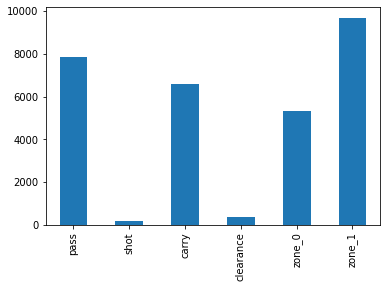

In [5]:
# bar chart of counts of first 4 columns in act_df
act_df.iloc[:].sum().plot.bar()

<AxesSubplot:>

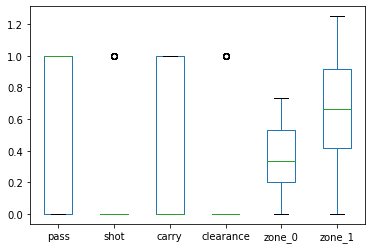

In [9]:
# boxplot of the last 2 columns of act_df
act_df.iloc[:].plot.box()

In [23]:
if 'observations' not in locals():

    ds = CreateDataset()
    ds.loadTrackingContentFromDir('three-sixty/*.json')
    ds.file_limit = 1
    ds.loadFilesFromDir('events/*.json', filterGamesWithoutTrackingData=True)
    observations, actions, rewards, event_ids, terminals = ds.createImageDataset()

    answers = {}
    players = {}

# observations = _split[0]
# actions = _split[1]

for i, situation in tqdm(enumerate(observations[50:100])):

    action_taken = actions[i]
    z0a, z1a = int(action_taken[0] * 11), int(action_taken[1] * 15)

    predictions = plas.predict([situation])

    t = {'id':event_ids[i]}
    print(event_ids[i])
    index = ds.get_index_of_event(t)


    print("get zone from event")
    print("action taken", action_taken[0], action_taken[1])
    zone1 = ds.get_zone_from_coords(action_taken[0] * 15, action_taken[1] * 11)
    print(zone1)

    e = ds.events[index]
    print(e[e['type']['name'].lower()]['end_location'])
    print(e['id'], e['type']['name'])

    z0p, z1p = int(predictions[0][0] * 11), int(predictions[0][1] * 15)

    # cv2.imshow("image1", situation[0])
    c1 = (255,255,0)
    c2 = (0,255,255)
    # conret situation[0] to rgb
    new_image = cv2.cvtColor(situation[0], cv2.COLOR_BGR2RGB)
    # new_image = ds.drawRect(ds.drawRect(situation[0], z0a, z1p, c1), z0p,z1p, c2)

    # double image size with cv2
    large = cv2.resize(new_image, (0, 0), fx=2, fy=2)
    large2 = cv2.resize(situation[1], (0, 0), fx=2, fy=2)
    large3 = cv2.resize(situation[2], (0, 0), fx=2, fy=2)

    legend = np.zeros(large.shape, large.dtype)
    
    # draw rectangle on legend
    cv2.rectangle(legend, (20, 20), (40, 40), c1, -1)
    cv2.rectangle(legend, (20, 60), (40, 80), c2, -1)

    # write text at 30,30 saying "TEAM MATES" on legend
    cv2.putText(legend, "ACTUAL", (50, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    cv2.putText(legend, "PREDICTED", (50, 70), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    ball_legend = np.zeros(large.shape, large.dtype)
    e_l = np.array(e[e['type']['name'].lower()]['end_location'] )

    ds.drawRect(large, e_l[0], e_l[0], c1),


    gzfc = ds.get_zone_from_coords(e_l[0], e_l[1])
    print(gzfc)
    print("before", e_l)
    e_l = e_l*2
    print("after", e_l)
    # draw circle at e_l on ball_legend
    # print(e_l)
    cv2.circle(large, (int(e_l[0]), int(e_l[1])), 5, (255, 0, 0), -1)

    cv2.imshow("large", large)
    cv2.imshow("legend", legend)
    # cv2.imshow("ball_legend", ball_legend)
    cv2.imshow("team_mates", large2)
    cv2.imshow("opposition", large3)

    # if q is pressed break the loop
    if cv2.waitKey(0) & 0xFF == ord('q'):
        cv2.destroyAllWindows()
        break
    else:
        cv2.destroyAllWindows()

    # break

    # break
    
    # if(p == "shot"):
    #     print(event_ids[i])
    #     print([ds.getPlayerFromActionID(event) for event in event_ids[i]])
    # event = ds.getActionFromID(event_ids[i][-2])
    

0it [00:00, ?it/s]

bbc398f7-c784-4958-a504-37b583caf97a
get zone from event
action taken 1.0 0.0
(0, 2)
[32.5, 28.8]
bbc398f7-c784-4958-a504-37b583caf97a Pass
(4, 4)
before [32.5 28.8]
after [65.  57.6]


0it [00:07, ?it/s]


In [ ]:
self.good_events = {
    'pass': self.PASS,
    'shot': self.SHOOT,
    'carry':self.CARRY,
    'clearance':self.CLEAR,
    # 'foul won': self.FOUL,
    'foul': self.FOUL,
}